
# Explainable AI: SHAP & LIME — Live/Visual Examples

This notebook gives you quick, reproducible **live/visual examples** you can drop into a 15‑minute talk:
- **Tabular (Loan-like) classification**: Train a model and explain a single decision with **LIME** and **SHAP**.
- **Global vs Local**: SHAP summary (global) and force/decision plots (local).
- **Text (Spam vs Ham)**: Use **LIME for text** to show why an email is flagged.

> Tip for presenting: Run the cells beforehand so the plots are cached; then step through them during the talk.



## References
- Ribeiro, M. T., Singh, S., & Guestrin, C. (2016). *“Why should I trust you?” Explaining the predictions of any classifier.* KDD ’16. https://arxiv.org/pdf/1602.04938  
- Lundberg, S. M., & Lee, S. I. (2017). *A unified approach to interpreting model predictions (SHAP).* NeurIPS. https://arxiv.org/pdf/1705.07874



## 0) Setup
If you don't already have the libraries installed, run the cell below.


In [3]:

# If needed, uncomment to install
# %pip install scikit-learn shap lime matplotlib numpy pandas
#!pip install shap
#!pip install lime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.6/547.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 6.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 17.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=70b458283f4749a11cab574df165ff7f4126ae3f182ff6bc01a6407ca824291c
  Stored in directory: /Users/joshuadollison/Library/Caches/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [23]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# XAI libs
import shap
from lime.lime_tabular import LimeTabularExplainer

# Matplotlib: one chart per plot, no explicit colors per presenter's preference.



## 1) Create a simple **loan-like** dataset (tabular)
We'll simulate features commonly used in credit decisions, then train a classifier.


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


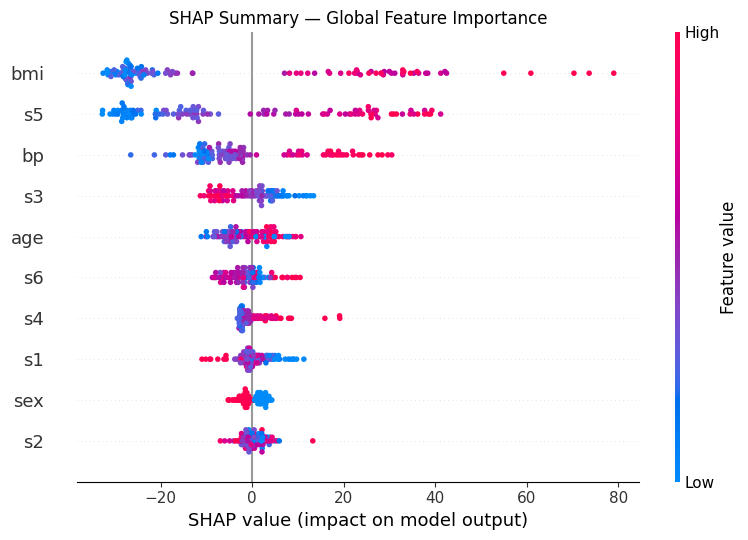

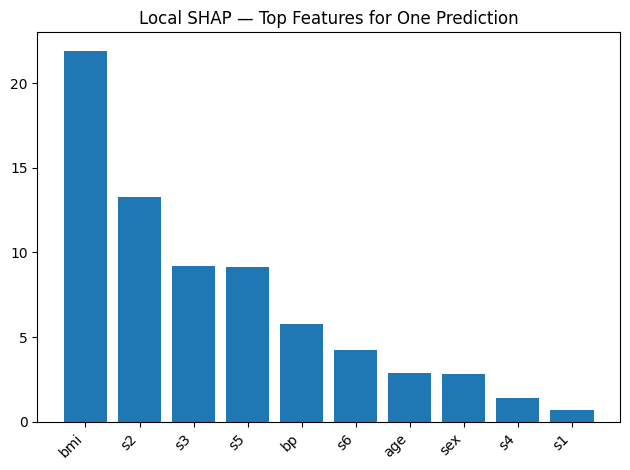

In [30]:
# ==== CLEAN SHAP DEMO (from scratch) ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes           # bundled regression dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap

# 1) Data
X, y = load_diabetes(return_X_y=True, as_frame=True)
feature_names = X.columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

display(X.head())

# 2) Model (tree model so TreeExplainer is fast & stable)
model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# 3) SHAP values (regression => single (n_samples, n_features) array; no class indexing)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)   # legacy API works reliably for trees on regression

# 4) Global summary (matplotlib; no JS)
plt.title("SHAP Summary — Global Feature Importance")
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()

# 5) Local explanation for one row (simple, robust static bar)
i = 5
sample = X_test.iloc[[i]]
local_sv = explainer.shap_values(sample)      # shape: (1, n_features)

vals = np.abs(local_sv[0])
idx = np.argsort(vals)[::-1][:10]

plt.bar(range(len(idx)), vals[idx])
plt.xticks(range(len(idx)), sample.columns[idx], rotation=45, ha="right")
plt.title("Local SHAP — Top Features for One Prediction")
plt.tight_layout()
plt.show()

LIME Explanation for One Prediction:
-0.03 < bmi <= -0.01: -29.6029
-0.03 < s5 <= -0.00: -14.4406
s3 > 0.03: -9.9343
-0.04 < bp <= -0.01: -8.0440
s1 > 0.03: -5.7373
0.00 < s6 <= 0.03: -4.0574
sex <= -0.04: 3.5538
-0.04 < s4 <= -0.00: -2.5956
s2 > 0.03: 1.1622
0.01 < age <= 0.04: 0.7229


/Users/joshuadollison/miniforge3/envs/py312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


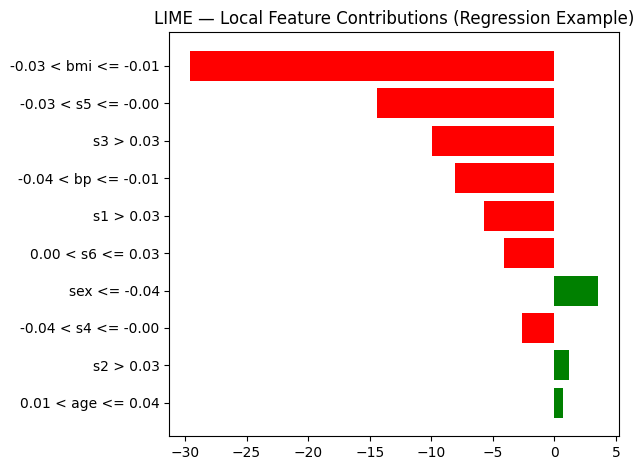

In [29]:
# ==== LIME DEMO (for same RandomForestRegressor) ====
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# 1) Prepare explainer
explainer_lime = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    mode='regression',
    discretize_continuous=True,
    verbose=False
)

# 2) Pick one instance to explain
i = 5
instance = np.array(X_test.iloc[i])

# 3) Generate explanation
exp = explainer_lime.explain_instance(
    data_row=instance,
    predict_fn=model.predict,
    num_features=10
)

# 4) Print textual explanation
print("LIME Explanation for One Prediction:")
for f, w in exp.as_list():
    print(f"{f}: {w:.4f}")

# 5) Plot explanation
fig = exp.as_pyplot_figure()
plt.title("LIME — Local Feature Contributions (Regression Example)")
plt.tight_layout()
plt.show()


## 5) **Text demo** — LIME for Spam vs Ham
A tiny example to show words driving a classification.


Predicted class: spam


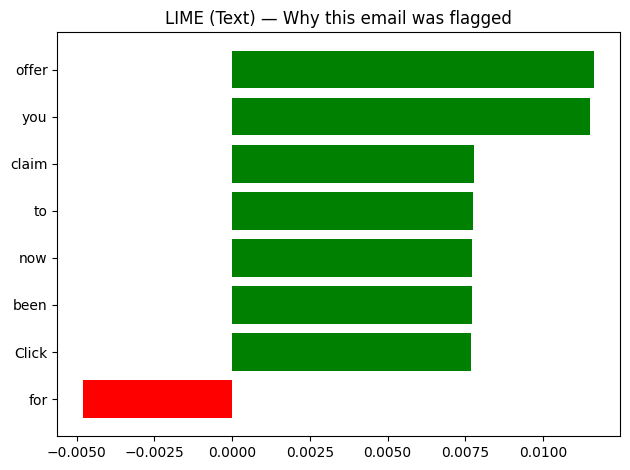

In [10]:

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from lime.lime_text import LimeTextExplainer

texts = [
    "Win a FREE prize now! Click to claim your lottery winnings",
    "Reminder: Project meeting today at 3pm on Zoom",
    "Exclusive offer just for you, limited time!!!",
    "Lunch tomorrow? I can pick the place",
    "Your account has been compromised, verify your password here",
    "Are we still on for golf Saturday?",
]
labels = np.array([1,0,1,0,1,0])  # 1=spam, 0=ham

pipe = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))
pipe.fit(texts, labels)

explainer_text = LimeTextExplainer(class_names=["ham","spam"])
test_email = "Congratulations, you have been selected for a special offer. Click now to claim."
pred = pipe.predict([test_email])[0]

print("Predicted class:", ["ham","spam"][pred])
exp_txt = explainer_text.explain_instance(
    test_email,
    pipe.predict_proba,
    num_features=8
)
fig = exp_txt.as_pyplot_figure()
plt.title("LIME (Text) — Why this email was flagged")
plt.tight_layout()
plt.show()



## 6) Presenter Notes
- **LIME**: say “local surrogate around one point” and note it's approximate → great *storytelling* for a single decision.
- **SHAP**: emphasize game theory + consistency; use **summary plot** for global view and **force plot** for the single applicant.
- Time check: Run LIME tabular + SHAP summary + one local force plot. Keep text demo if you have extra time.
